# Homework 8

Name: Eric Wu <br>
Date: 10/27/2025

## Contents

1. [Import Dependencies](#10-import-dependencies)
1. [Infection](#20-infection)
    1. [Change virus1 Values](#21-change-persondfvirus1-values)
    1. [Infect 10 Citizens](#22-infect-10-citizens)
1. [First Evolution](#30-first-evolution)
    1. [Plot 1](#31-plot-6-lists)
    1. [Plot 2](#32-plot-6-lists-ylog)
1. [Write Script for Each Region](#40-write-script-for-each-region)
    1. [Define New EvolveInfect](#41-evloveinfect_new-function)
    1. [Evolve 12 More Months](#42-evlove-for-another-12-months)
    1. [Plot 3](#43-24-month-span-plot-ylog)

### 1.0 Import dependencies

In [1]:
#mydir = '/home/jkinser/Documents/courses/CDSCardinal/Version5/'
#mydir = '/Users/jkinser/Documents/CoursesKinser/CDSCardinal/Version5/'

mydir = '/Users/eric/Documents/CDS465/'

pysrc = mydir + 'pysrc/'
datadir = mydir + 'data/'
popdir = mydir + 'population/'

import sys
sys.path.append( pysrc )

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
popfile = 'pop3_7.db' 

import Main, virus, island
E = Main.Realm( datadir )
E.ReadAll( popdir + popfile)
len(E.persondf)

#create CDC df
virus.CreateCDC(E)

### 2.0 Infection:

#### 2.1 Change persondf.virus1 values

In [3]:
E.persondf['virus1'] = (1 - np.random.rand(len(E.persondf))**2) #initialize virus propogation val

#### 2.2 Infect 10 Citizens

Select 10 citizens who are alive, and between the ages of 25 and 50. One citizen should be from each of
the cities, and the other five should be from the countryside (not in any city). <br>
Print [pid, firstname, lastname, locv, loch] for these 10 citizens.

In [4]:
#query suitable suitors to infect

s1 = ((E.month - E.persondf['birth']) >= 12*25) & ((E.month - E.persondf['birth']) < 12*50) # atleast 25y and less than 50y
s2 = E.persondf['death'] < 0 #persons must be alive to spread virus
potential_nfct = E.persondf.loc[s1&s2]

pids = island.PidsInCities(E)

In [5]:
#choose infected at random
nfct_n0 = list()
for i in range(len(pids)):
    if i == 5:
        nfct_n0.append(potential_nfct.loc[potential_nfct['pid'].isin(pids[i]),'pid'].sample(5,replace=False).values)
    else:
        nfct_n0.append(potential_nfct.loc[potential_nfct['pid'].isin(pids[i]),'pid'].sample(1).values)

nfct_n0 = np.concat(nfct_n0).flatten()

In [ ]:
#infection time!
virus.InfectThem(E, nfct_n0, 1)

#E.persondf.loc[E.persondf['pid'].isin(nfct_n0)][['pid','virus1']]

### 3.0 First Evolution

Using infectradius=10 and randgamma=0.5, evolve the population for 12 months. Use
virus.EvolveInfect instead of E.Evolve. <br>
For each month, collect the number of infected citizens in each city and the countryside. Collect this
data in 6 lists, one list for each city and one for the countryside. <br>
Plot these six lists.<br>
An example is shown below. There are six lines (five cities and one country). The x-axis is the number
of months (12), and the y-axis is the number of infected citizens.

In [7]:
#set global parameters
E.infectradius = 10
E.randgamma = 0.5
vnum = 1

#Use virus.EvolveInfect
#Collect the number of infected at each month. 
v_nfct = []

for i in range(12):
    virus.EvolveInfect(E, vnum)
    v_nfct.append(virus.CountSickInEachArea( E, pids, vnum ))

v_nfct = np.array(v_nfct).T
#print(v_nfct)

#### 3.1 Plot 6 lists

In [22]:
clrs = ['c', 'orange', 'green', 'red', 'm', 'brown']
lbls = [('country' if n == 6 else 'c' + str(n)) for n in range(1,6+1)]

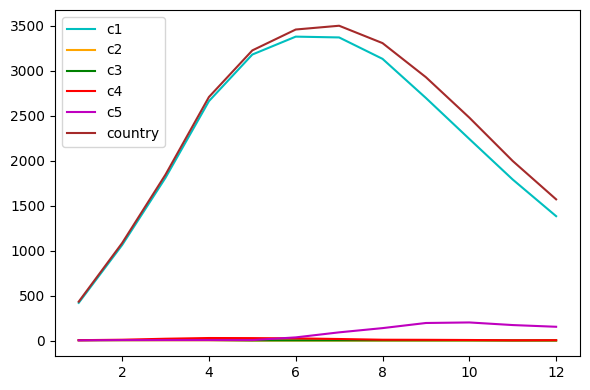

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
for i in range( 6 ):
    ax.plot(range(1,12+1), v_nfct[i],color = clrs[i],label=lbls[i])
    ax.legend(loc='best')
    #ax.set_yscale('log')
plt.tight_layout()
plt.show()

#### 3.2 Plot 6 lists (ylog)

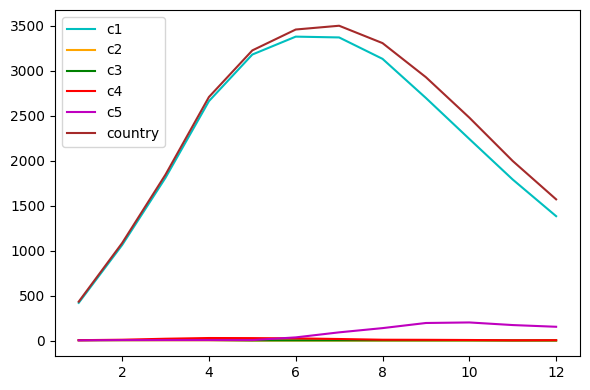

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
for i in range( 6 ):
    ax.plot(range(1,12+1), v_nfct[i],color = clrs[i],label=lbls[i])
    ax.legend(loc='best')
    #ax.set_yscale('log')
plt.tight_layout()
plt.show()


### 4.0 Write Script for Each Region

Twelve months have passed, and the CDC has figured out that there is a problem. Each city decides on
a different strategy to combat the illness: <br>

1. City 1: No action
2. City 2: All citizens are required to wear masks.
3. City 3: All citizens must practice social distancing.
4. City 4: Every month, 10% of the citizens receive the vaccination.
5. City 5: All citizens wear masks and practice social distancing.
6. Country: No action.

#### 4.1 EvloveInfect_new Function

In [26]:
def EvloveInfect_new(E, nmonths:int, vnum: int = 1, irads = [10, 10, 2, 10, 2, 10], gammas = [0.5, 0.1, 0.5, 0.5, 0.1, 0.5]):
    """
    This new EvolveInfect enables each location to have different behaviors in response to the virus. 
    This function returns a list of sick counts of each location per month.

    inpts:
        E: class Realm,
        nmonths (int): The number of months to evolve,
        vnum (int): The type of virus 
        irads (list): A list of infection radii behaviors per location,
        gammas (list): A list of infections gammas per location
    
    opts:
        v_nfct (list): a list that stores the sick count of each location per month 
    """
    v_nfct = [] #initialize list to store number of infected for each city and countryside

    for month in range(1, nmonths+1):
        ccpids = island.PidsInCities(E) #get new city pids each month; ppl may move
        tobesick = [] #reset tobesick each month

        for city in range(0,6): #apply different treatments to each location
            if city == 4-1: virus.VaxCity(E, random.sample(ccpids[city],int(0.1*len(ccpids[city])))) # if the city is c4, then vaccinate 10% of the population 
            a = virus.PossibleSick(E, gammas[i], irads[i], vnum, ccpids[i]) 
            tobesick.extend(a) 

        virus.InfectThem(E, tobesick, vnum) #infect populations
        healed = virus.AlmostWell(E, vnum) #assess which people are almost recovered
        E.Evolve(1, 0, 0, True) #evo one month
        virus.AdjustSickValues(E, healed) #adjust almost healed
        v_nfct.append(virus.CountSickInEachArea(E, ccpids, vnum)) #add count of infected for each city and countryside

    return v_nfct

#### 4.2 Evlove for another 12 months

In [27]:
v_nfct2 = EvloveInfect_new(E,12)
v_nfct2 = np.array(v_nfct2).T

#### 4.3 24 Month Span Plot (ylog)

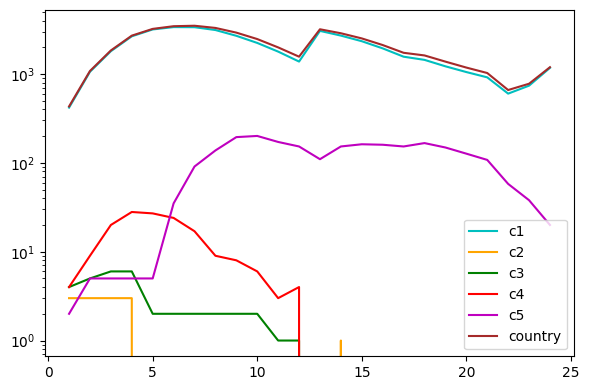

In [28]:
v_nfct_24 = np.concat((v_nfct,v_nfct2), axis = 1)

fig, ax = plt.subplots(figsize=(6, 4))
for i in range( 6 ):
    ax.plot(range(1,24+1), v_nfct_24[i],color = clrs[i],label=lbls[i])
    ax.legend(loc='best')
    ax.set_yscale('log')
plt.tight_layout()
plt.show()